In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame,Series
import seaborn as sns
from tqdm.notebook import tqdm
from datetime import datetime

import altair as alt
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer

from src.parsing import *
from src.text_split import extract_paragraphs, split_long_paragraphs, collapse_paragraphs_iteratively

sns.set_theme(style="whitegrid")
tqdm.pandas()

In [3]:
model = SentenceTransformer.load('./models/n8-all-MiniLM-L12-v2-2022-11-02_09-49-25')

In [5]:
data = read_post_data('./data/posts.csv')
data = data[data.htmlBody.notna()].copy()

In [6]:
h2t = get_html_parser()
data['body'] = data.htmlBody.progress_map(h2t.handle).map(str.strip)
data = data[data['body'].map(len) > 50].copy()

  0%|          | 0/10779 [00:00<?, ?it/s]

## Split data

In [7]:
max_n_words = 400
data['paragraphs'] = data.body.progress_map(extract_paragraphs)
data['paragraphs'] = data.paragraphs.progress_map(lambda p: split_long_paragraphs(p, max_n_words=max_n_words))
data['paragraphs_split'] = data.paragraphs.progress_map(lambda x: collapse_paragraphs_iteratively(x, max_n_words=max_n_words))

  0%|          | 0/10763 [00:00<?, ?it/s]

  0%|          | 0/10763 [00:00<?, ?it/s]

  0%|          | 0/10763 [00:00<?, ?it/s]

In [8]:
par_split_df = pd.concat([
    DataFrame({'postId': pid, 'text': r.paragraphs_split.text.values}) 
    for pid,r in data.iterrows()
], ignore_index=True)
par_split_df.shape

(72443, 2)

In [9]:
par_split_df.to_pickle('./data/par_split_df.pkl')

## Embed

### By paragraphs

In [47]:
pars_encoded = model.encode(par_split_df.text, batch_size=24, show_progress_bar=True)

Batches:   0%|          | 0/3019 [00:00<?, ?it/s]

In [50]:
# TODO: add weights base on n_words
posts_encoded = DataFrame(pars_encoded).groupby(par_split_df.postId.values).mean()
posts_encoded['body'] = data.body[posts_encoded.index]

In [51]:
posts_encoded.to_csv("./cache/posts_encoded.csv")

### By paragraph, baseline model

TODO:
- Make baseline embedding
- Test Parametric UMAP for the best model

In [10]:
model_baseline = SentenceTransformer.load('all-MiniLM-L12-v2')

In [11]:
pars_encoded_baseline = model_baseline.encode(par_split_df.text, batch_size=24, show_progress_bar=True)

Batches:   0%|          | 0/3019 [00:00<?, ?it/s]

In [ ]:
posts_encoded_baseline = DataFrame(pars_encoded_baseline).groupby(par_split_df.postId.values).mean()
posts_encoded_baseline['body'] = data.body[posts_encoded_baseline.index]
posts_encoded_baseline.to_csv("./cache/posts_encoded__baseline_minilm_l12.csv")

### By sentences

**This code was abandoned as processing by sentence is too time and memory intensive**

In [57]:
from nltk.tokenize import PunktSentenceTokenizer
sent_tokenizer = PunktSentenceTokenizer("\n\n".join(data.body.values))

In [58]:
sents_per_post = data.body.progress_map(sent_tokenizer.tokenize)

  0%|          | 0/10763 [00:00<?, ?it/s]

In [68]:
all_sents = np.concatenate(sents_per_post.values)

In [71]:
sents_encoded = model.encode(all_sents, batch_size=24, show_progress_bar=True)

In [1]:
# posts_encoded_by_sents = sents_per_post.progress_map(lambda sts: model.encode(sts, batch_size=24).mean(axis=0))

In [2]:
# sents_encoded = model.encode(par_split_df.text, batch_size=24, show_progress_bar=True)

## Analyse

In [26]:
from src.mnn_umap import prepare_umap_graph, full_umap

import sys
sys.path.append("/home/vpetukhov/other/NLPProjects/DMTransfer/")

from scripts.graph_clustering import get_igraph_from_umap_graph

from tqdm.notebook import tqdm
tqdm.pandas()

ModuleNotFoundError: No module named 'igraph'

In [23]:
umap_graph = prepare_umap_graph(posts_encoded, metric="cosine", init_nn=30, connectivity="min_tree", verbose=False)

In [24]:
mnn_emb = full_umap(
    posts_encoded, umap_graph, spread=10, min_dist=0.5, metric="cosine", random_state=42, verbose=True, n_epochs=2000
)

/home/vpetukhov/local/miniconda3/envs/nlp/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


  0%|          | 0/2000 [00:00<?, ?it/s]

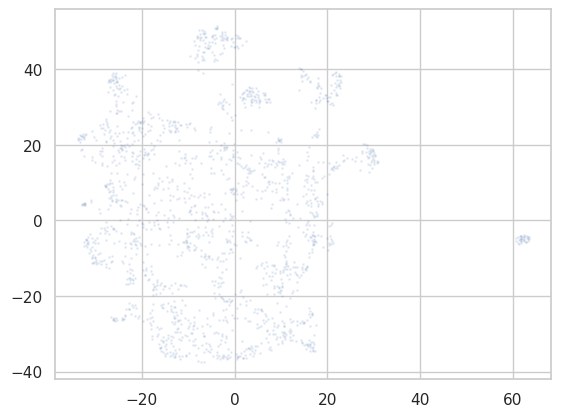

In [25]:
plt.scatter(mnn_emb[:,0], mnn_emb[:,1], s=1.0, marker='o', alpha=0.1);

In [ ]:
i_graph = get_igraph_from_umap_graph(None, graph=umap_graph)